In [1]:
# Import my own classes
import Prot_Post as Post
import OCTP_postprocess_CLASS as octp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import scipy.optimize as opt
import numpy as np

import scipy.constants as co

In [2]:
# Post.set_plot_settings(svg=False, tex=False)

In [3]:
def load_batch(runs, Ts_C, base_dir, heavy=None):
    temps = [r"Temp_" + str(T) + "/" for T in Ts_C]
    hist_log_res = []
    dt = []

    results = []
    results_err = []
    for j, T_C in enumerate(Ts_C):
        posts = []
        hist = []
        hist_log = []
        num_reactions = 0
        
        # load all runs for the temperature
        for run in runs:
            if heavy:
                string = "part_uH_"+str(heavy)+"/"
                posts.append(Post.Prot_Post(base_dir + r"Temp_" + str(T_C) + "/" + run + string, verbose=False))
            else:
                posts.append(Post.Prot_Post(base_dir + r"Temp_" + str(T_C) + "/" + run, verbose=False))
        
        # anlyse the reaction times
        for i, post in enumerate(posts):

            bins_log, h_log, _ = post.react_time(n_bins=75, bin_max=20000, lin=False, plotting=False)
            hist_log.append(h_log)
            
            num_reactions += np.shape(np.where(post.index_OH[1:] != post.index_OH[:-1])[0])[0]

        hist_log = np.array(hist_log)
        hist_log_ave, hist_log_err = Post.averages(hist_log, confidence=0.6827)
        
        results.append(hist_log_ave)
        results_err.append(hist_log_err)

        # test plot
        plt.plot(bins_log, hist_log_ave, label=f'log T = {T_C} C')
        color = plt.gca().lines[-1].get_color()  # Get the color of the last plotted line
        plt.fill_between(bins_log, hist_log_ave - hist_log_err, hist_log_ave + hist_log_err, color=color, alpha=0.3)
        
        # hist_res.append(hist_ave)
        hist_log_res.append(hist_log_ave)
        
        print(f'Temp {T_C}, num reaction {num_reactions}')

    plt.ylim(1e-7, 1)
    plt.yscale('log')
    plt.xscale('linear')
    plt.legend()
    plt.show()
    
    return results, results_err, dt, bins_log

### LOAD THE SAVED DATA
Normal Water
ALL TEMPERATURES

Temp 15, num reaction 17643
Temp 25, num reaction 20246
Temp 35, num reaction 22258
Temp 45, num reaction 24103
Temp 55, num reaction 25353
Temp 65, num reaction 26653


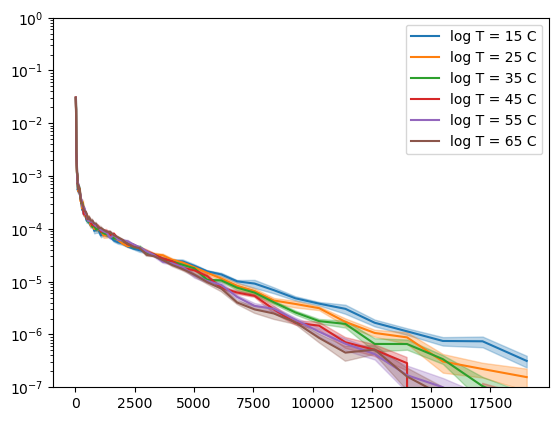

Temp 15, num reaction 13407
Temp 25, num reaction 15283
Temp 35, num reaction 17018
Temp 45, num reaction 18311
Temp 55, num reaction 19839
Temp 65, num reaction 20467


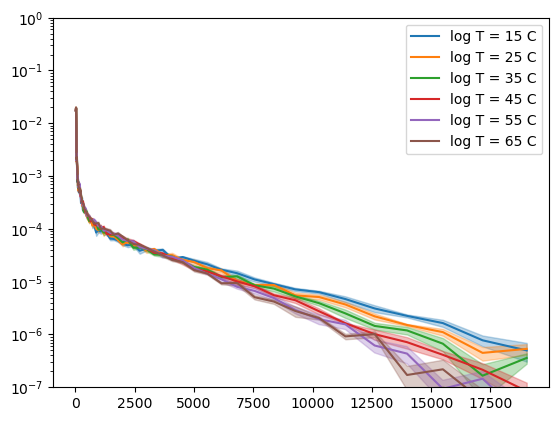

Temp 15, num reaction 11975
Temp 25, num reaction 13003
Temp 35, num reaction 14272
Temp 45, num reaction 15857
Temp 55, num reaction 16556
Temp 65, num reaction 17927


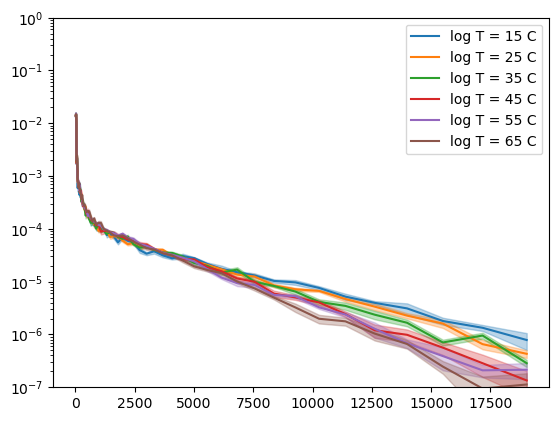

Temp 15, num reaction 7325
Temp 25, num reaction 8264
Temp 35, num reaction 9036
Temp 45, num reaction 9662
Temp 55, num reaction 10294
Temp 65, num reaction 10598


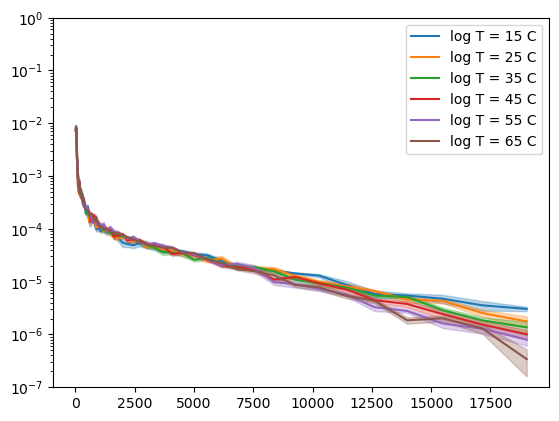

In [4]:
runs = [r"./run_1/", r"./run_2/", r"./run_3/", r"./run_4/", r"./run_5/", r"./run_6/"]
Ts_C = np.arange(15, 66, 10, dtype=np.int32)
base_dir = r"MLMD/"

results, results_err, dt, bins = load_batch(runs, Ts_C, base_dir)


base_dir = r"MLMD_heavy/"
results_heavy2, results_heavy2_err, dt_heavy2, bins_heavy2= load_batch(runs, Ts_C, base_dir, heavy="2")
results_heavy3, results_heavy3_err, dt_heavy3, bins_heavy3 = load_batch(runs, Ts_C, base_dir, heavy="3")
results_heavy10, results_heavy10_err, dt_heavy10, bins_heavy10 = load_batch(runs, Ts_C, base_dir, heavy="10")

### distribution gives tao

In [5]:
def custom_fit(bins, result, result_err, range_fit):
    # prep
    start, stop = range_fit
    hist_filt = result[start:stop]
    hist_err_filt = result_err[start:stop]
    bins_filt = bins[start:stop]
    
    #fit
    popt, pcov = opt.curve_fit(Post.exp_dist, bins_filt, hist_filt, sigma=hist_err_filt, absolute_sigma=True, p0=(3000, 0.2), maxfev=10000)
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters
    return popt[0], perr[0], popt[1], perr[1]

def fit_all(results, results_err, bins, Ts_C, range_fit, plotting=False, printing=False):
    tao = np.zeros(len(Ts_C))
    tao_err = np.zeros_like(tao)
    a = np.zeros_like(tao)
    a_err = np.zeros_like(tao)
    
    
    for i, result in enumerate(results):
        result_err = results_err[i]
        tao[i], tao_err[i], a[i], a_err[i] = custom_fit(bins/1000, result, result_err, range_fit)
        
        if printing:
            print("")
            print("T = result", Ts_C[i])
            print(f"Temp {Ts_C[i]}, tao {tao[i]:.5f} +- {2*tao_err[i]:.5f} ps, a {a[i]:.5f} +- {2*a_err[i]:.5f}")
        
        if plotting:
            # plot data
            plt.plot(bins, result, label=f'log T = {Ts_C[i]} C')
            color = plt.gca().lines[-1].get_color()  # Get the color of the last plotted line
            plt.fill_between(bins, result - result_err, result + result_err, color=color, alpha=0.25)
            
            # plot fit
            t = np.linspace(bins[range_fit[0]], bins[range_fit[1]], 1000)
            plt.plot(t, Post.exp_dist(t, tao[i], a[i]), color=color, linestyle='--')
            
            plt.axvline(x=bins[range_fit[0]], color='black', alpha=0.5)   
            plt.axvline(x=bins[range_fit[1]], color='black', alpha=0.5)
    
    if plotting:
        plt.ylim(1e-7, 1)
        plt.yscale('log')
        plt.xscale('linear')
        plt.legend()
        plt.show()
    
    return tao, tao_err, a, a_err

normal water

T = result 15
Temp 15, tao 3.20665 +- 0.14507 ps, a 0.00029 +- 0.00001

T = result 25
Temp 25, tao 2.69917 +- 0.12320 ps, a 0.00032 +- 0.00002

T = result 35
Temp 35, tao 2.43504 +- 0.08831 ps, a 0.00030 +- 0.00001

T = result 45
Temp 45, tao 2.11981 +- 0.08843 ps, a 0.00034 +- 0.00003

T = result 55
Temp 55, tao 2.09708 +- 0.09185 ps, a 0.00031 +- 0.00002

T = result 65
Temp 65, tao 1.96564 +- 0.07537 ps, a 0.00032 +- 0.00002


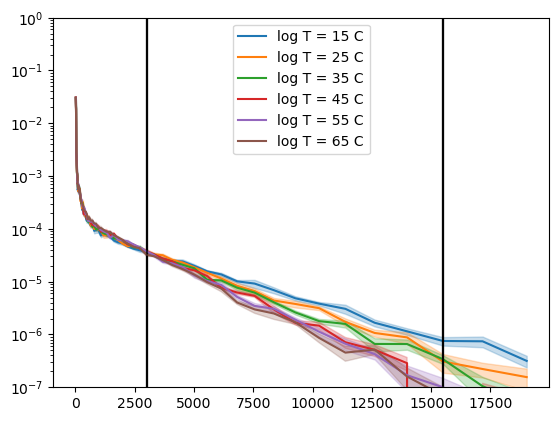


heavy water 2

T = result 15
Temp 15, tao 3.71868 +- 0.15416 ps, a 0.00034 +- 0.00002

T = result 25
Temp 25, tao 3.30102 +- 0.10541 ps, a 0.00033 +- 0.00002

T = result 35
Temp 35, tao 3.09484 +- 0.15257 ps, a 0.00031 +- 0.00002

T = result 45
Temp 45, tao 2.58745 +- 0.05434 ps, a 0.00035 +- 0.00002

T = result 55
Temp 55, tao 2.29271 +- 0.09938 ps, a 0.00038 +- 0.00002

T = result 65
Temp 65, tao 2.26855 +- 0.07345 ps, a 0.00036 +- 0.00002


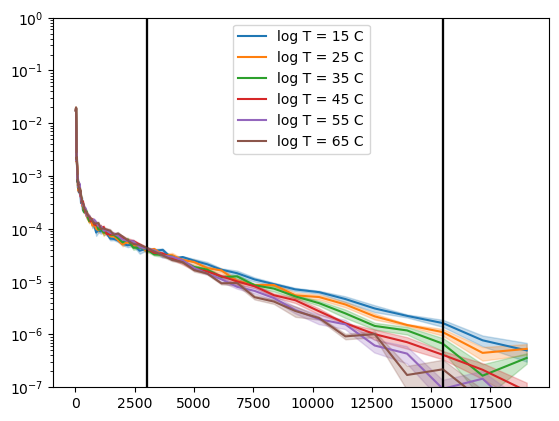


heavy water 3

T = result 15
Temp 15, tao 4.37156 +- 0.25869 ps, a 0.00033 +- 0.00001

T = result 25
Temp 25, tao 3.66210 +- 0.16075 ps, a 0.00036 +- 0.00002

T = result 35
Temp 35, tao 3.13712 +- 0.11592 ps, a 0.00038 +- 0.00001

T = result 45
Temp 45, tao 2.82723 +- 0.13684 ps, a 0.00038 +- 0.00002

T = result 55
Temp 55, tao 2.59982 +- 0.07297 ps, a 0.00039 +- 0.00001

T = result 65
Temp 65, tao 2.48721 +- 0.10760 ps, a 0.00038 +- 0.00002


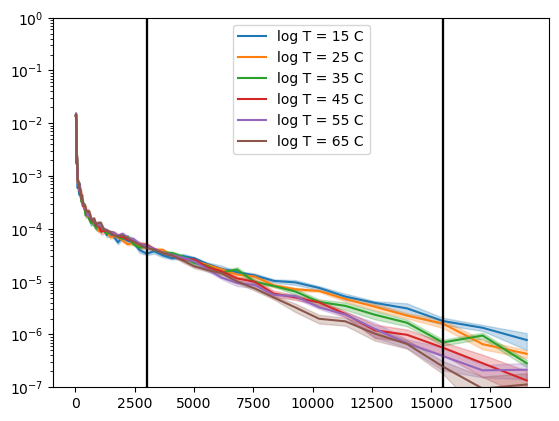


heavy water 10

T = result 15
Temp 15, tao 5.08495 +- 0.36792 ps, a 0.00043 +- 0.00002

T = result 25
Temp 25, tao 4.77811 +- 0.29238 ps, a 0.00042 +- 0.00002

T = result 35
Temp 35, tao 4.70670 +- 0.27304 ps, a 0.00040 +- 0.00002

T = result 45
Temp 45, tao 4.03673 +- 0.21180 ps, a 0.00043 +- 0.00002

T = result 55
Temp 55, tao 3.61969 +- 0.15059 ps, a 0.00045 +- 0.00002

T = result 65
Temp 65, tao 3.54018 +- 0.15893 ps, a 0.00045 +- 0.00002


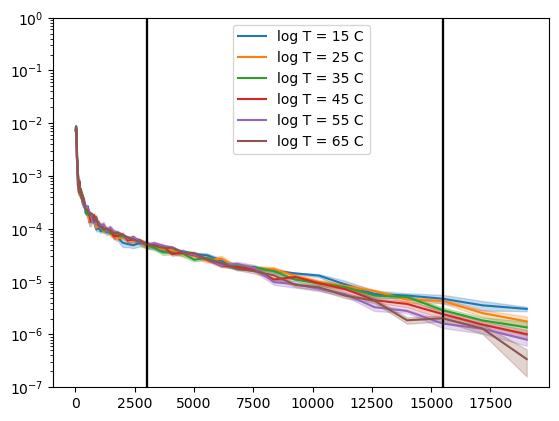

In [6]:
start = 42
stop = 58
range_fit = (start, stop)


# results, results_err, dt, bins
print("normal water")
tao, tao_err, a, a_err = fit_all(results, results_err, bins, Ts_C, range_fit=range_fit, plotting=True, printing=True)
print("")

print("heavy water 2")
tao_heavy2, tao_heavy2_err, a_heavy2, a_heavy2_err = fit_all(results_heavy2, results_heavy2_err, bins_heavy2, Ts_C, range_fit=range_fit, plotting=True, printing=True)
print("")

print("heavy water 3")
tao_heavy3, tao_heavy3_err, a_heavy3, a_heavy3_err = fit_all(results_heavy3, results_heavy3_err, bins_heavy3, Ts_C, range_fit=range_fit, plotting=True, printing=True)
print("")

print("heavy water 10")
tao_heavy10, tao_heavy10_err, a_heavy10, a_heavy10_err = fit_all(results_heavy10, results_heavy10_err, bins_heavy10, Ts_C, range_fit=range_fit, plotting=True, printing=True)
print("")

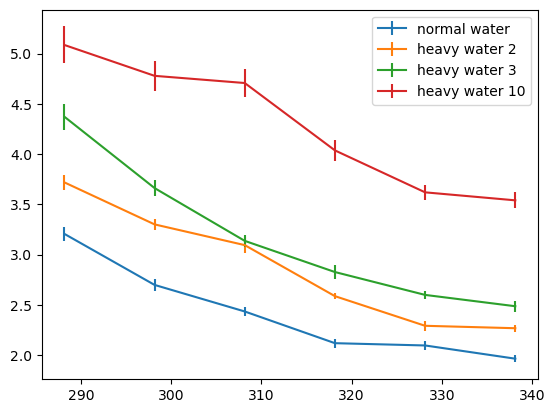

In [7]:
plt.figure()
plt.errorbar(Ts_C+co.zero_Celsius, tao, yerr=tao_err, label='normal water')
plt.errorbar(Ts_C+co.zero_Celsius, tao_heavy2, yerr=tao_heavy2_err, label='heavy water 2')
plt.errorbar(Ts_C+co.zero_Celsius, tao_heavy3, yerr=tao_heavy3_err, label='heavy water 3')
plt.errorbar(Ts_C+co.zero_Celsius, tao_heavy10, yerr=tao_heavy10_err, label='heavy water 10')
plt.legend()

### Inverse distribution gives lambda

In [8]:
def custom_fit(bins, result, result_err, range_fit):
    # prep
    start, stop = range_fit
    hist_filt = result[start:stop]
    hist_err_filt = result_err[start:stop]
    bins_filt = bins[start:stop]
    
    #fit
    popt, pcov = opt.curve_fit(Post.inv_exp_dist, bins_filt, hist_filt, sigma=hist_err_filt, absolute_sigma=True, p0=(1/3, 0.2), maxfev=10000)
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters
    return popt[0], perr[0], popt[1], perr[1]

def fit_all(results, results_err, bins, Ts_C, range_fit, plotting=False, printing=False):
    tao = np.zeros(len(Ts_C))
    tao_err = np.zeros_like(tao)
    a = np.zeros_like(tao)
    a_err = np.zeros_like(tao)
    
    
    for i, result in enumerate(results):
        result_err = results_err[i]
        tao[i], tao_err[i], a[i], a_err[i] = custom_fit(bins/1000, result, result_err, range_fit)
        
        if printing:
            print("")
            print("T = result", Ts_C[i])
            print(f"Temp {Ts_C[i]}, tao {tao[i]:.5f} +- {2*tao_err[i]:.5f} 1/ps, a {a[i]:.3f} +- {2*a_err[i]:.3f}")
        
        if plotting:
            # plot data
            plt.plot(bins, result, label=f'log T = {Ts_C[i]} C')
            color = plt.gca().lines[-1].get_color()  # Get the color of the last plotted line
            plt.fill_between(bins, result - result_err, result + result_err, color=color, alpha=0.25)
            
            # plot fit
            t = np.linspace(bins[range_fit[0]], bins[range_fit[1]], 1000)
            plt.plot(t, Post.inv_exp_dist(t, tao[i], a[i]), color=color, linestyle='--')
            
            plt.axvline(x=bins[range_fit[0]], color='black', alpha=0.5)   
            plt.axvline(x=bins[range_fit[1]], color='black', alpha=0.5)
    
    if plotting:
        plt.ylim(1e-7, 1)
        plt.yscale('log')
        plt.xscale('linear')
        plt.legend()
        plt.show()
    
    return tao, tao_err, a, a_err

normal water

T = result 15
Temp 15, tao 0.31185 +- 0.01411 1/ps, a 0.000 +- 0.000

T = result 25
Temp 25, tao 0.37048 +- 0.01691 1/ps, a 0.000 +- 0.000

T = result 35
Temp 35, tao 0.41067 +- 0.01489 1/ps, a 0.000 +- 0.000

T = result 45
Temp 45, tao 0.47174 +- 0.01968 1/ps, a 0.000 +- 0.000

T = result 55
Temp 55, tao 0.47685 +- 0.02089 1/ps, a 0.000 +- 0.000

T = result 65
Temp 65, tao 0.50874 +- 0.01951 1/ps, a 0.000 +- 0.000


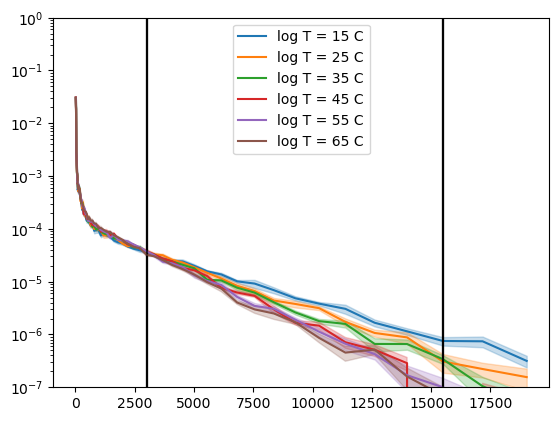


heavy water 2

T = result 15
Temp 15, tao 0.26891 +- 0.01115 1/ps, a 0.000 +- 0.000

T = result 25
Temp 25, tao 0.30294 +- 0.00967 1/ps, a 0.000 +- 0.000

T = result 35
Temp 35, tao 0.32312 +- 0.01593 1/ps, a 0.000 +- 0.000

T = result 45
Temp 45, tao 0.38648 +- 0.00812 1/ps, a 0.000 +- 0.000

T = result 55
Temp 55, tao 0.43616 +- 0.01891 1/ps, a 0.000 +- 0.000

T = result 65
Temp 65, tao 0.44081 +- 0.01427 1/ps, a 0.000 +- 0.000


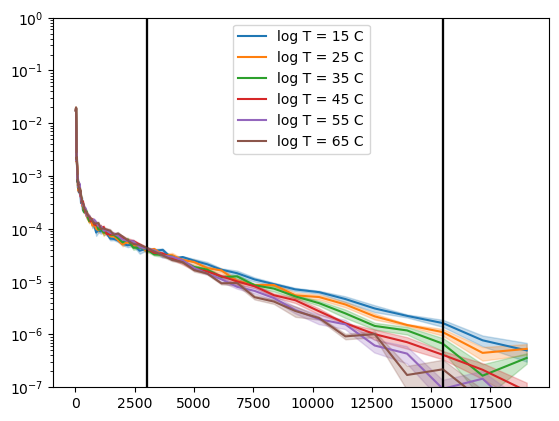


heavy water 3

T = result 15
Temp 15, tao 0.22875 +- 0.01354 1/ps, a 0.000 +- 0.000

T = result 25
Temp 25, tao 0.27307 +- 0.01199 1/ps, a 0.000 +- 0.000

T = result 35
Temp 35, tao 0.31876 +- 0.01178 1/ps, a 0.000 +- 0.000

T = result 45
Temp 45, tao 0.35370 +- 0.01712 1/ps, a 0.000 +- 0.000

T = result 55
Temp 55, tao 0.38464 +- 0.01080 1/ps, a 0.000 +- 0.000

T = result 65
Temp 65, tao 0.40206 +- 0.01739 1/ps, a 0.000 +- 0.000


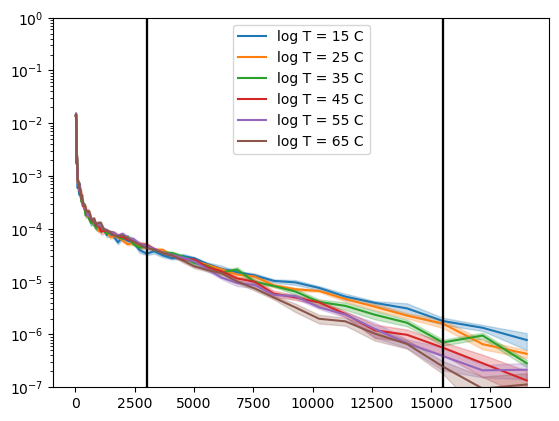


heavy water 10

T = result 15
Temp 15, tao 0.19666 +- 0.01423 1/ps, a 0.000 +- 0.000

T = result 25
Temp 25, tao 0.20929 +- 0.01281 1/ps, a 0.000 +- 0.000

T = result 35
Temp 35, tao 0.21246 +- 0.01233 1/ps, a 0.000 +- 0.000

T = result 45
Temp 45, tao 0.24773 +- 0.01300 1/ps, a 0.000 +- 0.000

T = result 55
Temp 55, tao 0.27627 +- 0.01149 1/ps, a 0.000 +- 0.000

T = result 65
Temp 65, tao 0.28247 +- 0.01268 1/ps, a 0.000 +- 0.000


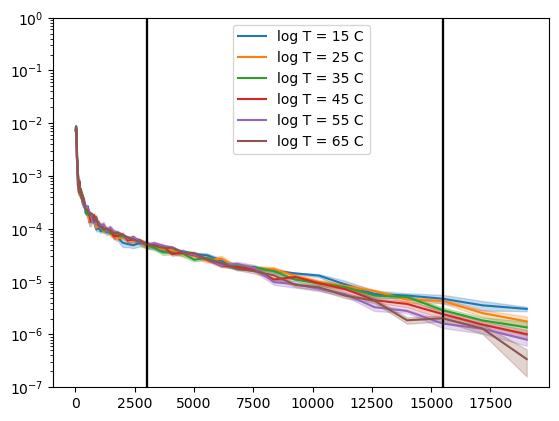

In [9]:
# start = 40
# stop = 58
# range_fit = (start, stop)


# results, results_err, dt, bins
print("normal water")
tao, tao_err, a, a_err = fit_all(results, results_err, bins, Ts_C, range_fit=range_fit, plotting=True, printing=True)
results_min = np.array(results) - 2*np.array(results_err)
results_max = np.array(results) + 2*np.array(results_err)

np.savetxt('plot6/normal_water', np.column_stack((bins/1000, results[0], results_min[0], results_max[0], results[1], results_min[1], results_max[1],
                                               results[2], results_min[2], results_max[2], results[3], results_min[3], results_max[3],
                                               results[4], results_min[4], results_max[4], results[5], results_min[5], results_max[5])), delimiter=' ',
           header="bin res_15 min_15 max_15 res_25 min_25 max_25 res_35 min_35 max_35 res_45 min_45 max_45 res_55 min_55 max_55 res_65 min_65 max_65", comments="")
print("")

print("heavy water 2")
tao_heavy2, tao_heavy2_err, a_heavy2, a_heavy2_err = fit_all(results_heavy2, results_heavy2_err, bins_heavy2, Ts_C, range_fit=range_fit, plotting=True, printing=True)
results_min = np.array(results_heavy2) - np.array(results_heavy2_err)
results_max = np.array(results_heavy2) + np.array(results_heavy2_err)
np.savetxt('plot6/heavy_2', np.column_stack((bins/1000, results_heavy2[0], results_min[0], results_max[0], results_heavy2[1], results_min[1], results_max[1],
                                               results_heavy2[2], results_min[2], results_max[2], results_heavy2[3], results_min[3], results_max[3],
                                               results_heavy2[4], results_min[4], results_max[4], results_heavy2[5], results_min[5], results_max[5])), delimiter=' ',
           header="bin res_15 min_15 max_15 res_25 min_25 max_25 res_35 min_35 max_35 res_45 min_45 max_45 res_55 min_55 max_55 res_65 min_65 max_65", comments="")
print("")

print("heavy water 3")
tao_heavy3, tao_heavy3_err, a_heavy3, a_heavy3_err = fit_all(results_heavy3, results_heavy3_err, bins_heavy3, Ts_C, range_fit=range_fit, plotting=True, printing=True)
results_min = np.array(results_heavy3) - np.array(results_heavy3_err)
results_max = np.array(results_heavy3) + np.array(results_heavy3_err)
np.savetxt('plot6/heavy_3', np.column_stack((bins/1000, results_heavy3[0], results_min[0], results_max[0], results_heavy3[1], results_min[1], results_max[1],
                                               results_heavy3[2], results_min[2], results_max[2], results_heavy3[3], results_min[3], results_max[3],
                                               results_heavy3[4], results_min[4], results_max[4], results_heavy3[5], results_min[5], results_max[5])), delimiter=' ',
           header="bin res_15 min_15 max_15 res_25 min_25 max_25 res_35 min_35 max_35 res_45 min_45 max_45 res_55 min_55 max_55 res_65 min_65 max_65", comments="")
print("")

print("heavy water 10")
tao_heavy10, tao_heavy10_err, a_heavy10, a_heavy10_err = fit_all(results_heavy10, results_heavy10_err, bins_heavy10, Ts_C, range_fit=range_fit, plotting=True, printing=True)
print("")

estimated energy barier normal water = -0.08218711943097709 eV
estimated energy barier 2u water = -0.08299606084954159 eV
estimated energy barier 3u water = -0.09470574463551999 eV
estimated energy barier 10u water = -0.0608091546136258 eV


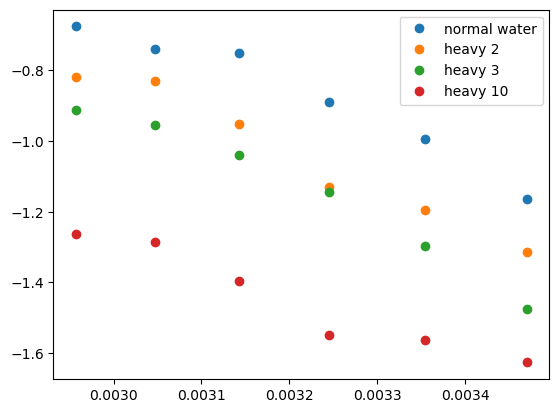

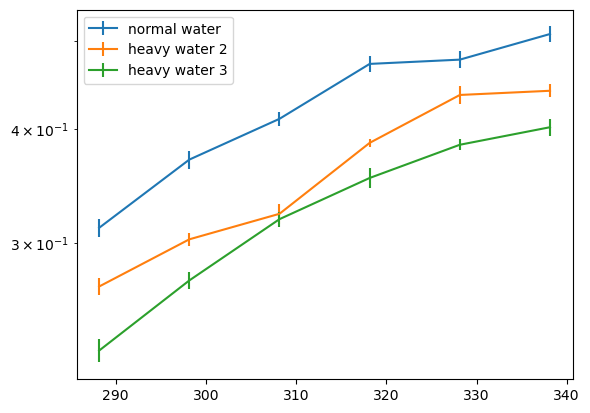

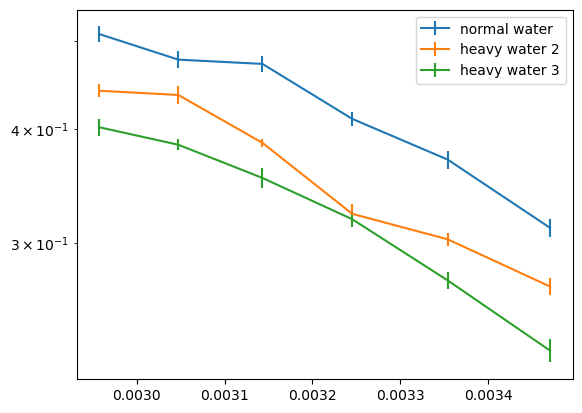

In [10]:
plt.figure()
x = 1/(Ts_C+co.zero_Celsius)

y = np.log(tao)
plt.errorbar(x, y, fmt='o', label='normal water')

e_barr = (y[-1]-y[0])/(x[-1]-x[0])*co.physical_constants['Boltzmann constant in eV/K'][0]  # eV/atom
print(f"estimated energy barier normal water = {e_barr} eV")

y = np.log(tao_heavy2)
plt.errorbar(x, y, fmt='o', label='heavy 2')

e_barr = (y[-1]-y[0])/(x[-1]-x[0])*co.physical_constants['Boltzmann constant in eV/K'][0]  # eV/atom
print(f"estimated energy barier 2u water = {e_barr} eV")

y = np.log(tao_heavy3)
plt.errorbar(x, y, fmt='o', label='heavy 3')

e_barr = (y[-1]-y[0])/(x[-1]-x[0])*co.physical_constants['Boltzmann constant in eV/K'][0]  # eV/atom
print(f"estimated energy barier 3u water = {e_barr} eV")

y = np.log(tao_heavy10)
plt.errorbar(x, y, fmt='o', label='heavy 10')

e_barr = (y[-1]-y[0])/(x[-1]-x[0])*co.physical_constants['Boltzmann constant in eV/K'][0]  # eV/atom
print(f"estimated energy barier 10u water = {e_barr} eV")

plt.legend()

plt.figure()
plt.errorbar(Ts_C+co.zero_Celsius, tao, yerr=tao_err, label='normal water')
plt.errorbar(Ts_C+co.zero_Celsius, tao_heavy2, yerr=tao_heavy2_err, label='heavy water 2')
plt.errorbar(Ts_C+co.zero_Celsius, tao_heavy3, yerr=tao_heavy3_err, label='heavy water 3')
plt.yscale('log')

plt.legend()

plt.figure()
plt.errorbar(1/(Ts_C+co.zero_Celsius), tao, yerr=tao_err, label='normal water')
plt.errorbar(1/(Ts_C+co.zero_Celsius), tao_heavy2, yerr=tao_heavy2_err, label='heavy water 2')
plt.errorbar(1/(Ts_C+co.zero_Celsius), tao_heavy3, yerr=tao_heavy3_err, label='heavy water 3')
plt.yscale('log')

plt.legend()

In [11]:
def arrhenius_eV(T, A, E):
    return A*np.exp(-E/(co.physical_constants['Boltzmann constant in eV/K'][0]*T))  # eV version

def arrhenius_kJ(T, A, E):
    return A*np.exp(-E/(co.R*T/1000))  # kJ version

def fit_arrhenius(Ts_C: np.ndarray, tao: np.ndarray, tao_err: np.ndarray, arrhenius=arrhenius_eV, plotting: bool=False, plot_col: str='C0', printing: bool=False):
    T = Ts_C + co.zero_Celsius
    
    popt, pcov = opt.curve_fit(arrhenius, T, tao, sigma=tao_err, absolute_sigma=True, p0=(50, 0.05), maxfev=10000)
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters
    
    if printing:
        print(f"reaction constant = {popt[0]:.2e} +- {2*perr[0]:.2e}, E_barrier = {popt[1]:.3f} +- {2*perr[1]:.3f}")
    
    if plotting:
        x = 1/T
        y = np.log(tao)
        
        T_fit = np.linspace(280, 350, 100)
        tao_fit = arrhenius(T_fit, popt[0], popt[1])
        x_fit = 1/T_fit
        y_fit = np.log(tao_fit)        
        
        plt.figure('Arrhenius space')
        plt.errorbar(x, y, fmt='o', label='data', color=plot_col)
        plt.plot(x_fit, y_fit, label='fit', linestyle='--', color=plot_col)
        
        plt.figure('real space')
        plt.errorbar(T-co.zero_Celsius, tao, yerr=tao_err, fmt='o', label='data', color=plot_col)
        plt.plot(T_fit-co.zero_Celsius, tao_fit, label='fit', linestyle='--', color=plot_col)
    
    return popt[0], perr[0], popt[1], perr[1]

In [12]:
# Tfit = np.linspace(280, 350, 20)
# A, A_err, E, E_err = fit_arrhenius(Ts_C, tao, tao_err, printing=True, plotting=True, plot_col='C0', arrhenius=arrhenius_kJ)

# np.savetxt('plot6/arrh_point_normal_water', np.column_stack((Ts_C, tao, 2*tao_err)), delimiter=' ',
#            header="T tao err", comments="")
# np.savetxt('plot6/arrh_fit_normal_water', np.column_stack((Tfit - co.zero_Celsius, arrhenius_kJ(Tfit, A, E))), delimiter=' ',
#            header="T tao", comments="")

# A, A_err, E, E_err = fit_arrhenius(Ts_C, tao_heavy2, tao_heavy2_err, printing=True, plotting=True, plot_col='C1', arrhenius=arrhenius_kJ)
# np.savetxt('plot6/arrh_point_heavy_2', np.column_stack((Ts_C, tao_heavy2, tao_heavy2_err)), delimiter=' ',
#            header="T tao err", comments="")
# np.savetxt('plot6/arrh_fit_heavy)_2', np.column_stack((Tfit - co.zero_Celsius, arrhenius_kJ(Tfit, A, E))), delimiter=' ',
#            header="T tao", comments="")

# A, A_err, E, E_err = fit_arrhenius(Ts_C, tao_heavy3, tao_heavy3_err, printing=True, plotting=True, plot_col='C2', arrhenius=arrhenius_kJ)
# np.savetxt('plot6/arrh_point_heavy_3', np.column_stack((Ts_C, tao_heavy3, tao_heavy3_err)), delimiter=' ',
#            header="T tao err", comments="")
# np.savetxt('plot6/arrh_fit_heavy)_3', np.column_stack((Tfit - co.zero_Celsius, arrhenius_kJ(Tfit, A, E))), delimiter=' ',
#            header="T tao", comments="")

# # A, A_err, E, E_err = fit_arrhenius(Ts_C, tao_heavy10, tao_heavy10_err, printing=True, plotting=True, plot_col='C3', arrhenius=arrhenius_kJ)

# plt.figure('Arrhenius space')
# plt.xlabel('1/T [1/K]')
# plt.ylabel('ln(tao) [ln(1/ps)]')
# plt.legend()

# plt.figure('real space')
# plt.xlabel('T [C]')
# plt.ylabel('tao [1/ps]')
# plt.legend()

reaction constant = 8.09e+00 +- 2.48e+00, E_barrier = 7.685 +- 0.799
reaction constant = 9.43e+00 +- 2.50e+00, E_barrier = 8.509 +- 0.693
reaction constant = 1.02e+01 +- 3.29e+00, E_barrier = 8.956 +- 0.851


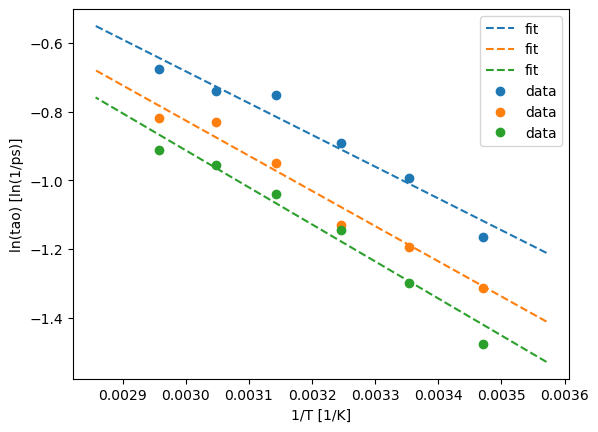

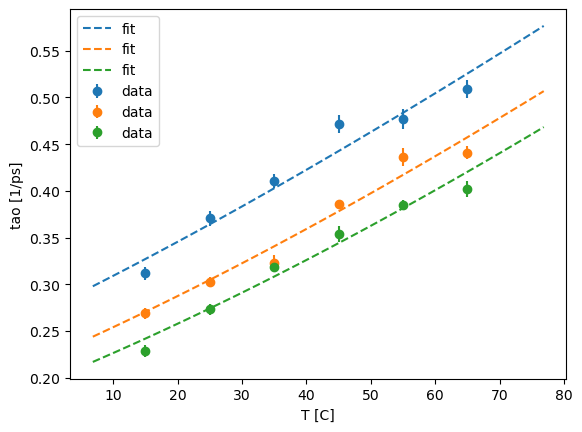

In [13]:
Tfit = np.linspace(280, 350, 20)
A, A_err, E, E_err = fit_arrhenius(Ts_C, tao, tao_err, printing=True, plotting=True, plot_col='C0', arrhenius=arrhenius_kJ)

np.savetxt('plot6/arrh_point_normal_water', np.column_stack((1/(Ts_C+co.zero_Celsius), np.log(tao), np.abs(np.log(tao)-np.log(tao-2*tao_err)), np.abs(np.log(tao) - np.log(tao+2*tao_err)))), delimiter=' ',
           header="T tao up down", comments="")
np.savetxt('plot6/arrh_fit_normal_water', np.column_stack((1/Tfit, np.log(arrhenius_kJ(Tfit, A, E)))), delimiter=' ',
           header="T tao", comments="")

A, A_err, E, E_err = fit_arrhenius(Ts_C, tao_heavy2, tao_heavy2_err, printing=True, plotting=True, plot_col='C1', arrhenius=arrhenius_kJ)
np.savetxt('plot6/arrh_point_heavy_2', np.column_stack((1/(Ts_C+co.zero_Celsius), np.log(tao_heavy2), np.abs(np.log(tao_heavy2) - np.log(tao_heavy2-2*tao_heavy2_err)), np.abs(np.log(tao_heavy2) - np.log(tao_heavy2+2*tao_heavy2_err)))), delimiter=' ',
           header="T tao up down", comments="")
np.savetxt('plot6/arrh_fit_heavy_2', np.column_stack((1/Tfit, np.log(arrhenius_kJ(Tfit, A, E)))), delimiter=' ',
           header="T tao", comments="")

A, A_err, E, E_err = fit_arrhenius(Ts_C, tao_heavy3, tao_heavy3_err, printing=True, plotting=True, plot_col='C2', arrhenius=arrhenius_kJ)
np.savetxt('plot6/arrh_point_heavy_3', np.column_stack((1/(Ts_C+co.zero_Celsius), np.log(tao_heavy3), np.abs(np.log(tao_heavy3) - np.log(tao_heavy3-2*tao_heavy3_err)), np.abs(np.log(tao_heavy3) - np.log(tao_heavy3+2*tao_heavy3_err)))), delimiter=' ',
           header="T tao up down", comments="")
np.savetxt('plot6/arrh_fit_heavy_3', np.column_stack((1/Tfit, np.log(arrhenius_kJ(Tfit, A, E)))), delimiter=' ',
           header="T tao", comments="")

# A, A_err, E, E_err = fit_arrhenius(Ts_C, tao_heavy10, tao_heavy10_err, printing=True, plotting=True, plot_col='C3', arrhenius=arrhenius_kJ)

plt.figure('Arrhenius space')
plt.xlabel('1/T [1/K]')
plt.ylabel('ln(tao) [ln(1/ps)]')
plt.legend()

plt.figure('real space')
plt.xlabel('T [C]')
plt.ylabel('tao [1/ps]')
plt.legend()